<a href="https://colab.research.google.com/github/ShlokArora2709/Deep-Learning/blob/master/GANs_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets.cifar10 import load_data

(x_train, y_train), (x_test, y_test) = load_data()
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [2]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Conv2D,Dropout,LeakyReLU,Conv2DTranspose,Reshape
from keras.utils import plot_model
import numpy as np

In [3]:
def discriminator(input_shape=(32,32,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def define_generator(latent_dim):
	model = Sequential()
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


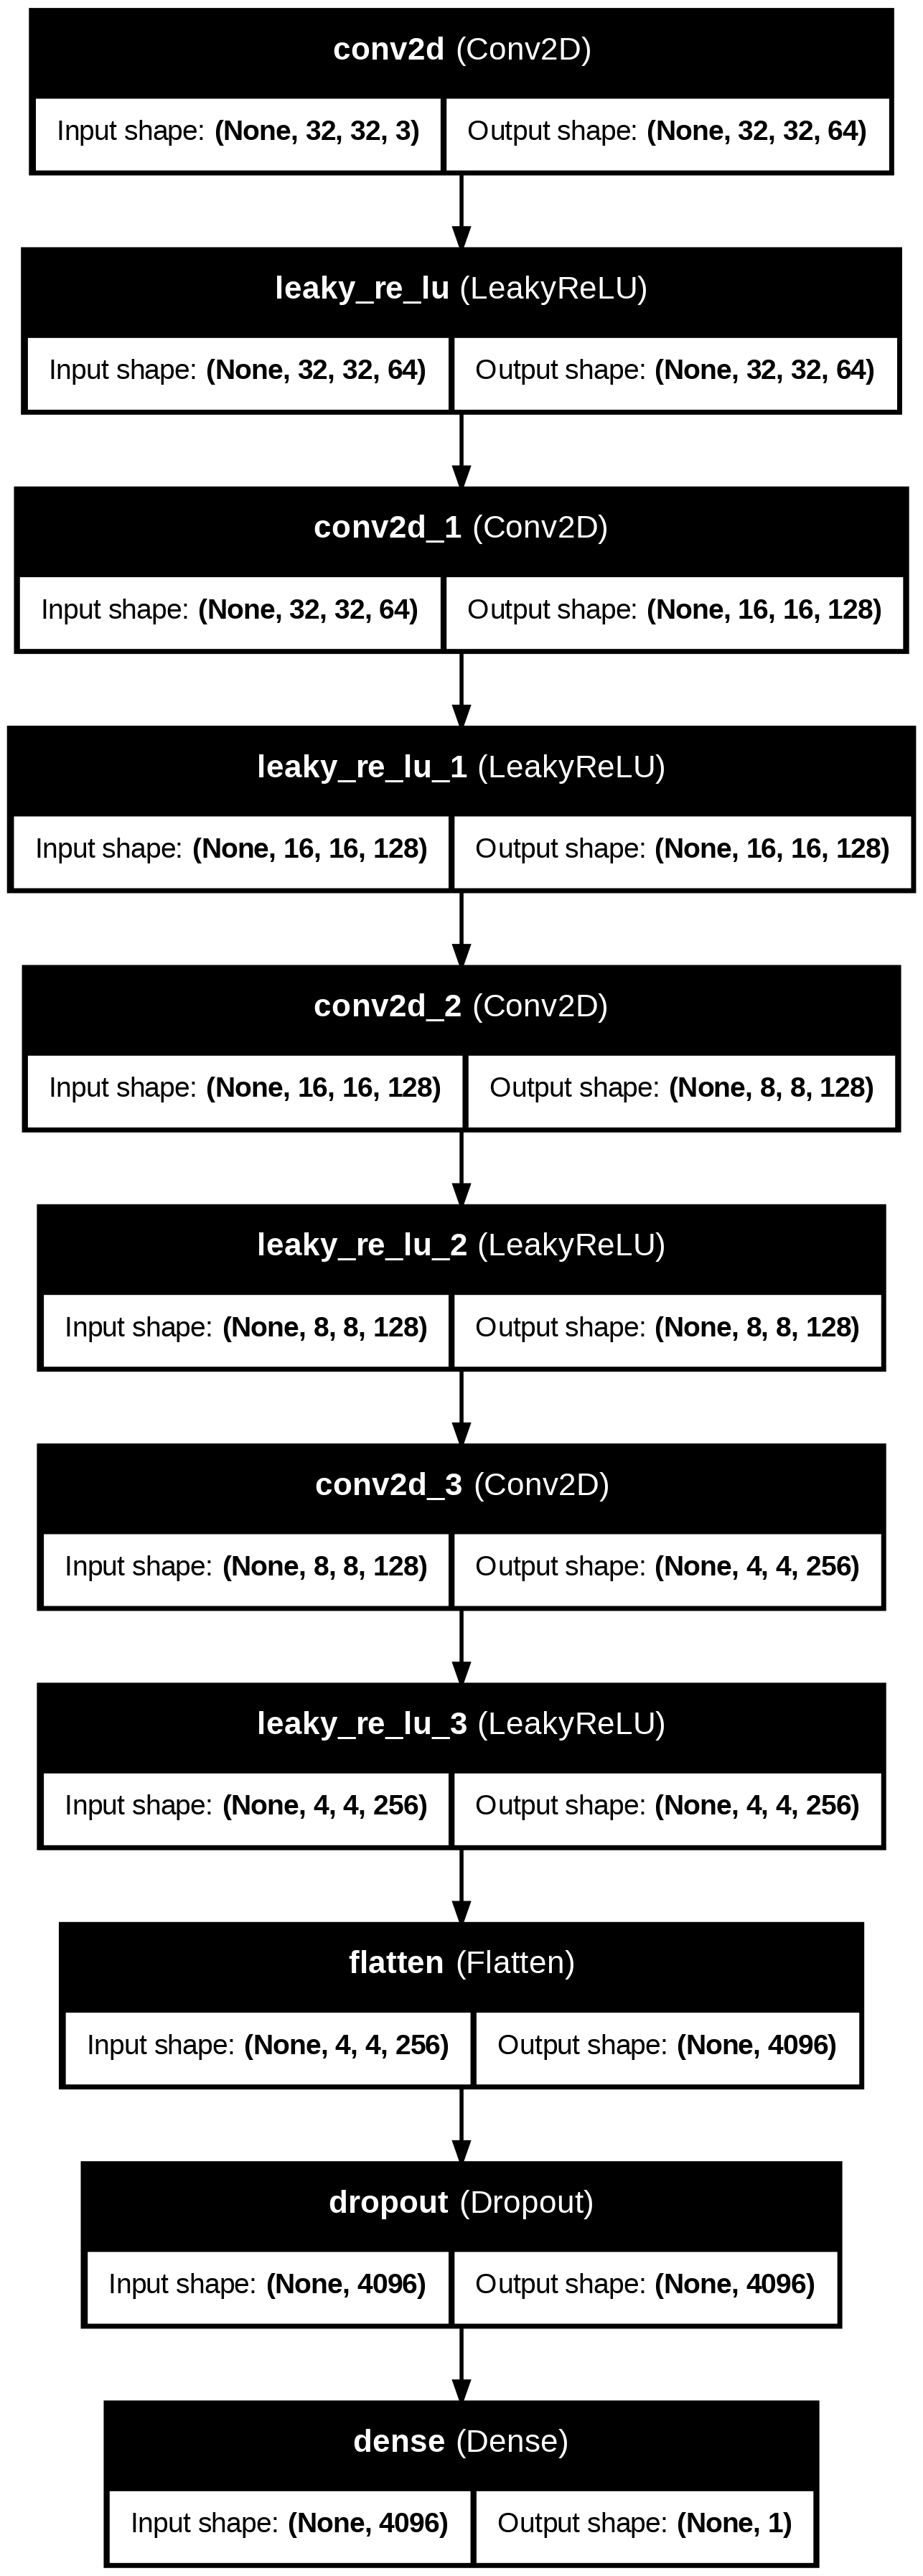

In [4]:
plot_model(discriminator(), show_shapes=True, show_layer_names=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


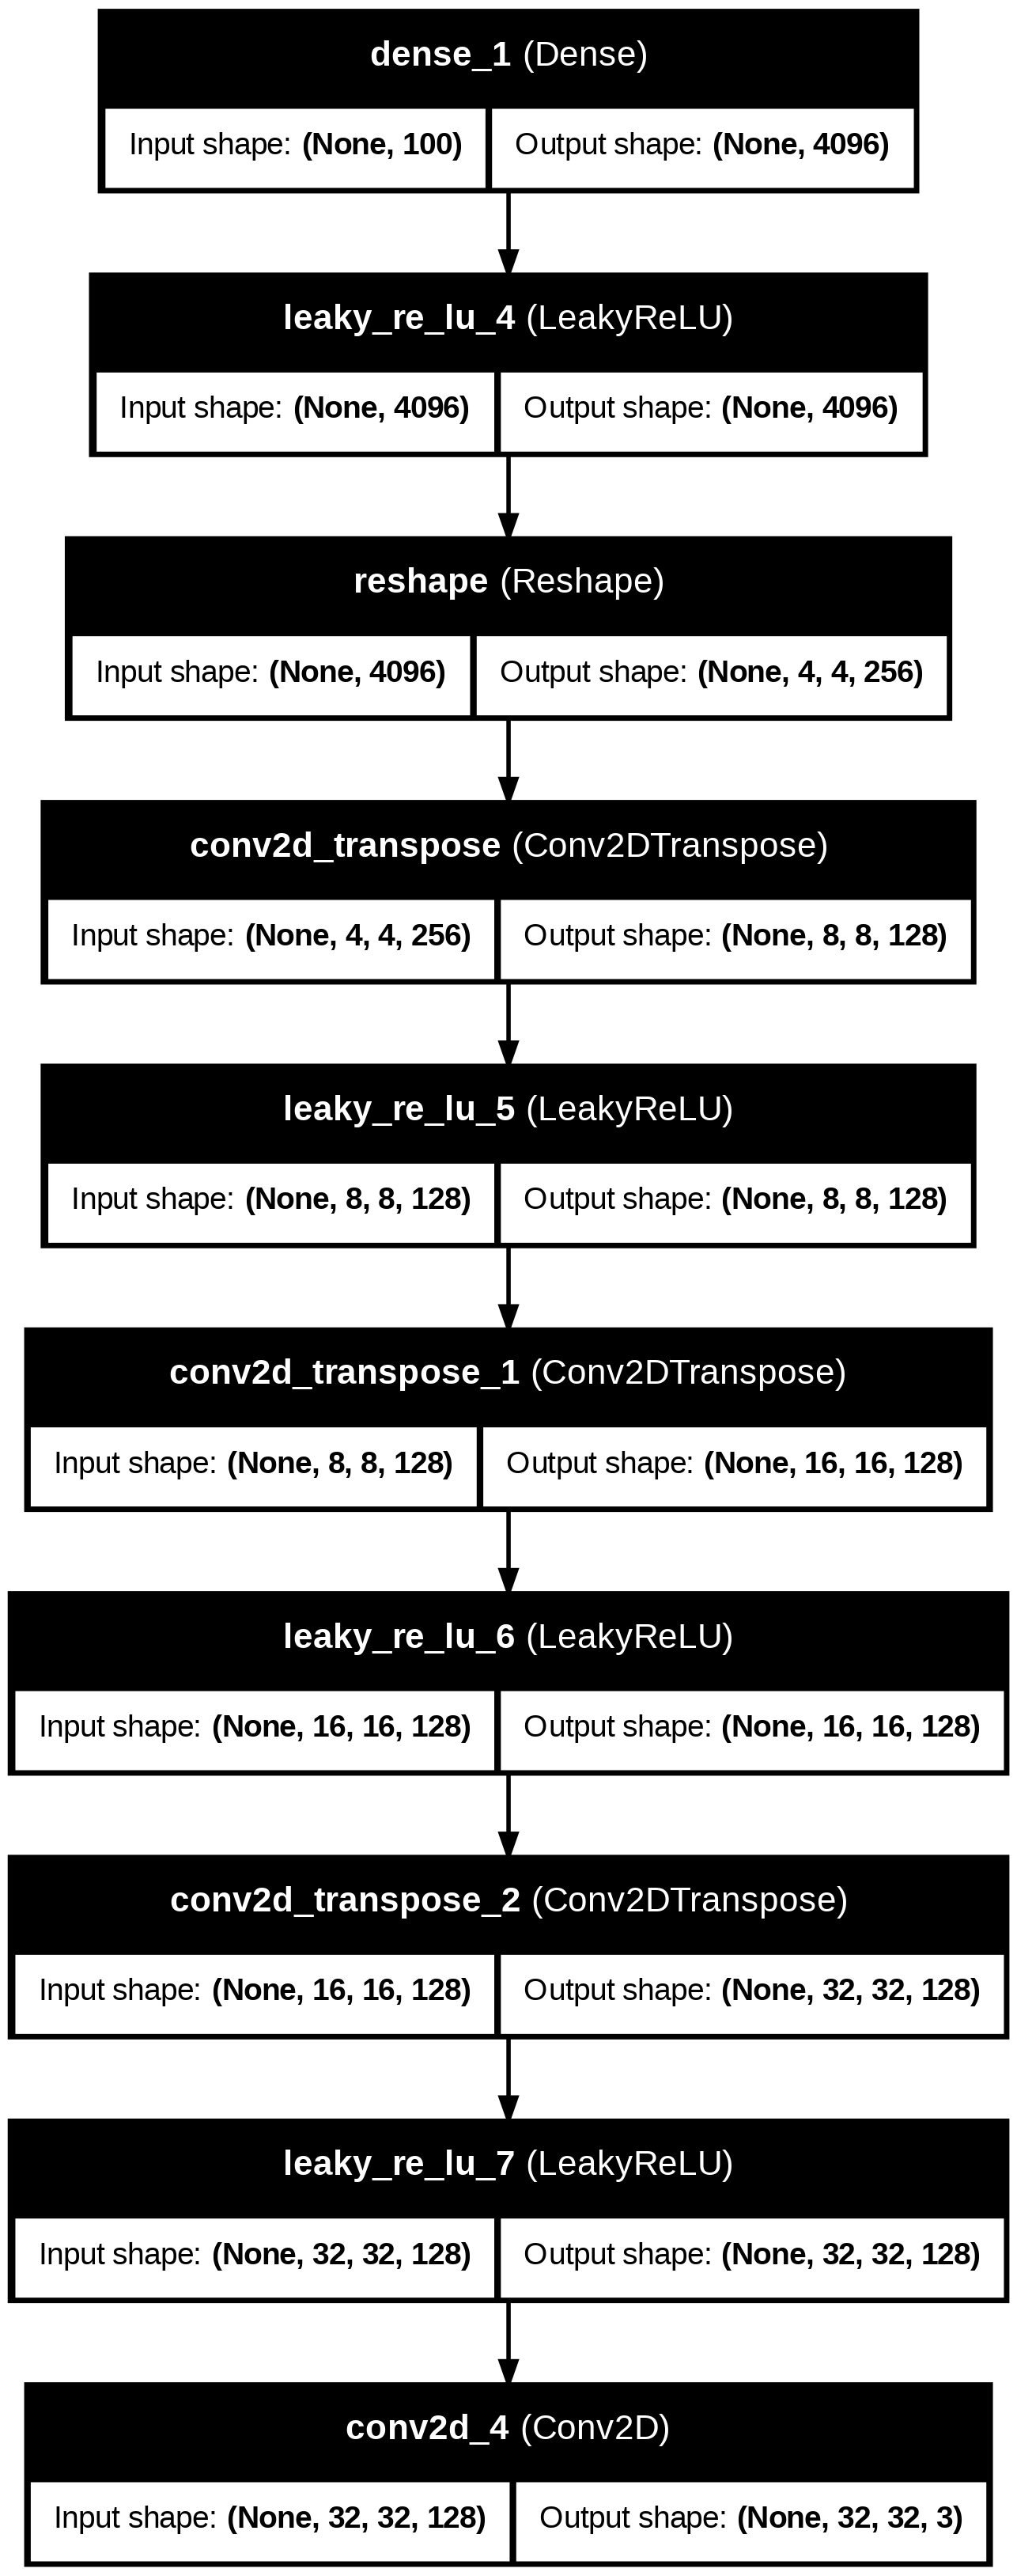

In [5]:
plot_model(define_generator(100), show_shapes=True, show_layer_names=True)

In [6]:
from numpy.random import randint,randn
from numpy import ones,zeros

def load_real_samples():
	(trainX, _), (_, _) = load_data()
	X = trainX.astype('float32')
	X = (X - 127.5) / 127.5
	return X

def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y

In [7]:
X,y=generate_real_samples(load_real_samples(), 64)
print(X.shape, y.shape)

(64, 32, 32, 3) (64, 1)


In [8]:
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input


def generate_fake_samples(g_model, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  X = g_model.predict(x_input)
  y = zeros((n_samples, 1))
  del x_input
  return X, y

In [9]:
def define_gan(g_model, d_model):
	d_model.trainable = False
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	opt = Adam(beta_1=0.5,learning_rate=0.0002)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [10]:
from matplotlib import pyplot
import gc
def save_plot(examples, epoch, n=7):
  examples = (examples + 1) / 2.0
  for i in range(n * n):
    pyplot.subplot(n, n, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(examples[i])
  filename = 'generated_plot_e%03d.png' % (epoch+1)
  pyplot.savefig(filename)
  pyplot.close()
  del examples, fig, axes
  gc.collect()

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  X_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  save_plot(x_fake, epoch)
  del X_real, y_real, x_fake, y_fake  # clear variables
  gc.collect()


def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
			# Get real images
      X_real, y_real = generate_real_samples(dataset, half_batch)
			# Update discriminator's weights
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# Generate fake images
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# Update discriminator's weights again
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# Prepare random input for generator
      X_gan = generate_latent_points(latent_dim, n_batch)
			# Label the fake images as real
      y_gan = ones((n_batch, 1))
			# Update generator based on discriminator's results
      g_loss = gan_model.train_on_batch(X_gan, y_gan)

      del X_real, y_real, X_fake, y_fake, X_gan, y_gan
      gc.collect()

    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [11]:
latent_dim = 100
d_model = discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
gan_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 32, 32, 3)           │       1,466,115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 1)                   │         522,497 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,988,612 (7.59 MB)

 Trainable params: 1,466,115 (5.59 MB)

 Non-trainable params: 522,497 (1.99 MB)

In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim)